# Project 01

## Setup

In [3]:
from pymonntorch import *

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import math
import random

## LIF Behavior

In [107]:
def LIF(I, threshold = -10, reset = -80, rest = -65, tau = 10, dt = 0.1) :
    n = len(I)

    V = torch.zeros(n)
    V[0] = rest

    spikes = torch.tensor([])
    R = 10

    voltage = rest
    for i in range(n - 1) :
        V_rec[i] = voltage

        dV = ((-V[k] - rest) + R*I[i]) / tau
        V[k + 1] = V[k] + dt*dV

        if(V[k] > threshold) : # fire a spike
            V[k + 1] = reset
            time = i * dt
            torch.cat((spikes, [time]))



# CurrentBehavior

In [403]:
class CurrentBehavior(Behavior) : 
    
    def initialize(self, neuron) :
        super().initialize(neuron)
        
        neuron.I = neuron.vector("zeros")
        
        self.pw = self.parameter("pw", 20)
        self.has_noise = self.parameter("has_noise", False)
        self.mode = self.parameter("mode", "constant")
        self.iter = 1
        self.func = self.parameter("custom", None)
        
        if(self.mode == "constant") : 
            def constant_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return (cnt > 1) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = constant_curr
        
        elif(self.mode == "trigeometric") : 
            def trigeometric_curr(cnt) : 
                return (math.sin(cnt/360 * np.pi))**2 * self.pw + self.has_noise * (random.random() * self.pw - random.random() * 1.5*self.pw)
            
            self.func = trigeometric_curr

        elif(self.mode == "random") : 
            def random_curr(cnt) : 
                a, res, state = np.random.rand(5) * self.pw, 0, 1
                for i in a : 
                    res += state * i
                    state *= -1
                return res
            
            self.func = random_curr
        
        elif(self.mode == "step") : 
            def step_curr(cnt) : 
                tp = random.random() < 0.5
                x = 1
                if(tp) : 
                    x *= -1

                return ((cnt > 1 and cnt < 40)) * (self.pw + self.has_noise * (random.random() * self.pw - self.pw/2 * x) / 2)
            
            self.func = step_curr

        elif(self.mode == "stair") : 
            def stair(cnt) : 
                return neuron.I + self.pw
            
            self.func = stair

        else :
            self.func = self.parameter("custom", None)


    def forward(self, neuron) : 
        neuron.I += (self.func(self.iter) - neuron.I)
        self.iter += 1

In [404]:
def input_current(mode, cnt, hasNoise = False, pw = 20) : 
    if(mode == 1) :
        return (math.sin(cnt/360 * np.pi))**2 * pw + hasNoise * (random.random() * pw - random.random() * 1.5*pw)
    elif(mode == 2) : 
        tp = random.random() < 0.5
        x = 1
        if(tp) : 
            x *= -1

        return (cnt > 200) * (pw + hasNoise * (random.random() * pw/2 * x))
    elif(mode == 3) : 
        a = np.random.rand(5) * pw
        res = 0
        state = 1
        for i in a : 
            res += state * i
            state *= -1
        return res
    elif(mode == 4) : 
        a = np.random.rand(5) * pw - pw/4
        res = 0
        state = 1
        for i in a : 
            res += state * i
            state *= -1
        
        return (cnt < 600) * res
    elif(mode == 5) : 
        tp = random.random() < 0.5
        x = 1
        if(tp) : 
            x *= -1

        return ((cnt > 100 and cnt < 400) or cnt > 700) * (pw + hasNoise * (random.random() * pw/2 * x))


In [7]:
class LIF_Behavior(Behavior) :

    def initialize(self, neuron) : 
        super().initialize(neuron)

        self.threshold = self.parameter("threshold", -10)
        neuron.reset = self.parameter("reset", -80)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 0.1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("ones") * neuron.rest

    def forward(self, neuron) : 
        firing = neuron.voltage >= self.threshold
        neuron.spike = firing.byte()
        neuron.voltage[firing] = neuron.reset

        dV = (-(neuron.voltage - neuron.rest) + neuron.R * neuron.I) / neuron.tau
        neuron.voltage += dV * neuron.dt
        

In [44]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 30, has_noise = True, mode = "constant"),
    1 : LIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [45]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=30,has_noise=True,mode=constant,)1:LIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
100xBatch: 1/1 (100%) 71.808ms


71.8083381652832

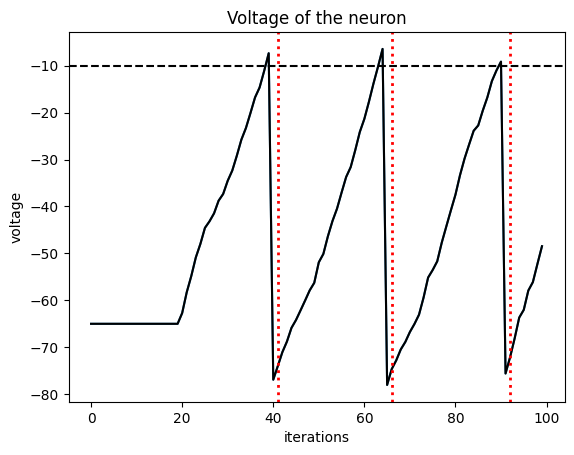

In [46]:
plt.plot(net['voltage', 0][:,0:1])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['LIF_Behavior', 0].threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')

for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
    
plt.show()

# plt.plot(net['spike.t', 0], net['spike.i', 0], '.k')
# plt.xlabel('iterations')
# plt.ylabel('neuron index')
# plt.title('Raster Plot')
# plt.show()

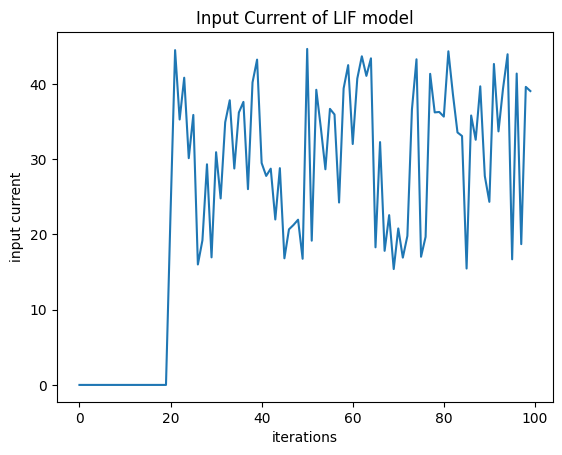

In [47]:
plt.plot(net['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()

# Exponential LIF

In [185]:
class ELIF_Behavior(Behavior) : 

    def initialize(self, neuron) : 
        super().initialize(neuron)

        self.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -80)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 0.1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("ones") * neuron.rest

        # Exponential parameters

        self.rh_threshold = self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 5)
        
        neuron.spike_zone = False

    def forward(self, neuron) : 
        firing = torch.BoolTensor([(neuron.voltage >= self.rh_threshold and not neuron.spike_zone)])
            
        if(firing) : 
            neuron.spike_zone = True
        elif(not firing and neuron.voltage < self.rh_threshold) :
            neuron.spike_zone = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= self.threshold
        neuron.voltage[reset_need] = neuron.reset

        dV = (
            -(neuron.voltage - neuron.rest) * (not neuron.spike_zone)
            + neuron.delta*torch.exp(torch.tensor([(neuron.voltage - self.rh_threshold) / neuron.delta]))
            + neuron.R*neuron.I 
            ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt
        neuron.voltage = torch.minimum(neuron.voltage, neuron.vector(100))

In [113]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 10, has_noise = False, mode = "constant"),
    1 : ELIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [68]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=constant,)1:AELIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 844.778ms


844.7778224945068

AttributeError: 'NoneType' object has no attribute 'threshold'

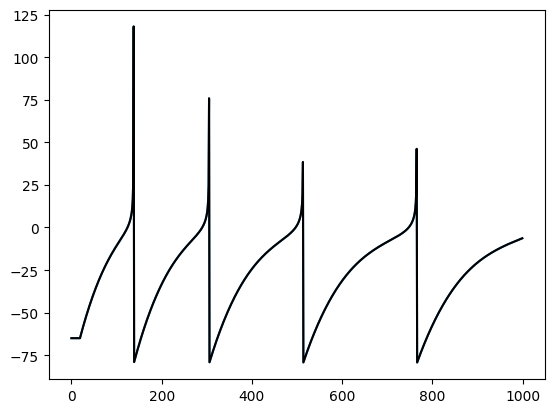

In [69]:
plt.plot(net['voltage', 0][:,0:1])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['ELIF_Behavior', 0].threshold, color='black', linestyle='--')
plt.axhline(ng['ELIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

Text(0.5, 1.0, 'Input Current of LIF model')

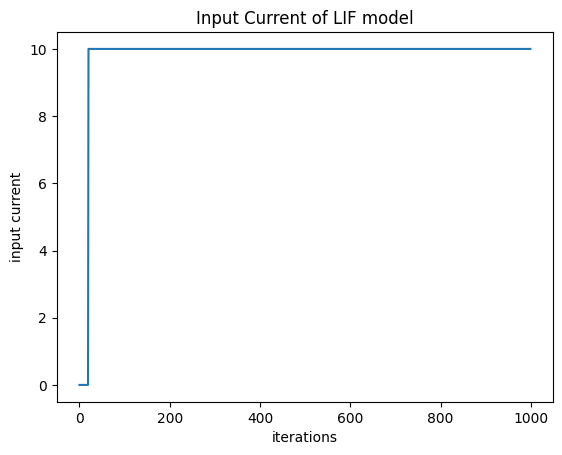

In [52]:
plt.plot(net['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

# Adaptive Exponential LIF (AELIF)

In [423]:
class AELIF_Behavior(Behavior) : 

    def initialize(self, neuron) : 
        super().initialize(neuron)

        # main LIF
        # -----------------------------------------------------------

        self.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -80)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 0.1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("ones") * neuron.rest

        # Exponential parameters

        self.rh_threshold = self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 5)

        neuron.spike_zone = False

        # Adaptability
        # -----------------------------------------------------------
        
        neuron.a = self.parameter("a", 0.2) # sub-threshold adaptation variable
        neuron.b = self.parameter("b", 0.7) # spike-triggered adaptation variable

        neuron.w = 0 # adaptive variable
        neuron.adpt_tau = self.parameter("adpt_tau", 10) # time-constant for w

    def forward(self, neuron) : 
        firing = torch.BoolTensor([(neuron.voltage >= self.rh_threshold and not neuron.spike_zone)])
            
        if(firing) : 
            neuron.spike_zone = True
        elif(not firing and neuron.voltage < self.rh_threshold) :
            neuron.spike_zone = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= self.threshold
        neuron.voltage[reset_need] = neuron.reset

        dV = (
            -(neuron.voltage - neuron.rest) * (not neuron.spike_zone)
            + neuron.delta*torch.exp(torch.tensor([(neuron.voltage - self.rh_threshold) / neuron.delta]))
            + neuron.R*neuron.I 
            - neuron.R*neuron.w * (not neuron.spike_zone)
        ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt

        dW = (
            + neuron.a*(neuron.voltage - neuron.rest)
            - neuron.w
            + neuron.b*neuron.adpt_tau*(firing.byte())
        ) / neuron.adpt_tau

        neuron.w += dW * neuron.dt

In [129]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 10, has_noise = False, mode = "constant"),
    1 : AELIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [130]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=constant,)1:AELIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 1002.357ms


1002.356767654419

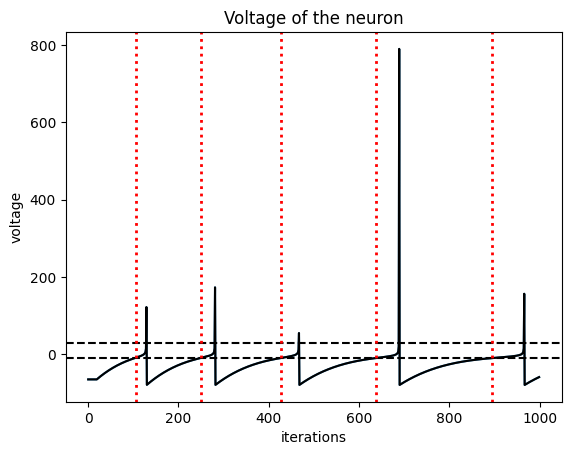

In [91]:
plt.plot(net['voltage', 0][:,0:1])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['AELIF_Behavior', 0].threshold, color='black', linestyle='--')
plt.axhline(ng['AELIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

Text(0.5, 1.0, 'Input Current of LIF model')

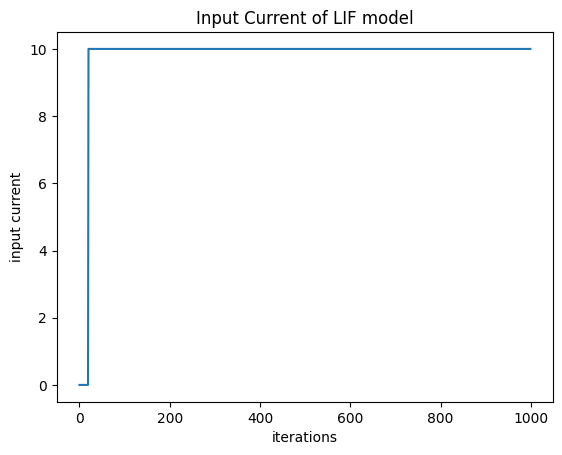

In [57]:
plt.plot(net['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

# Experiment

In [424]:
net1 = Network()

ng1 = NeuronGroup(net = net1, size = 1, behavior={
    0 : CurrentBehavior(pw = 12, has_noise = True, mode = "step"),
    1 : LIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net1, src=ng1, dst=ng1, tag='GLUTAMATE')

net1.initialize()
net1.simulate_iterations(400)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=12,has_noise=True,mode=step,)1:LIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
400xBatch: 1/1 (100%) 277.256ms


277.2560119628906

In [425]:
net2 = Network()

ng2 = NeuronGroup(net = net2, size = 1, behavior={
    0 : CurrentBehavior(pw = 12, has_noise = True, mode = "step"),
    1 : ELIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn2 = SynapseGroup(net=net2, src=ng2, dst=ng2, tag='GLUTAMATE')

net2.initialize()
net2.simulate_iterations(400)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=12,has_noise=True,mode=step,)1:ELIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
400xBatch: 1/1 (100%) 409.906ms


409.90614891052246

In [426]:
net3 = Network()

ng3 = NeuronGroup(net = net3, size = 1, behavior={
    0 : CurrentBehavior(pw = 12, has_noise = True, mode = "step"),
    1 : AELIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn3 = SynapseGroup(net=net3, src=ng3, dst=ng3, tag='GLUTAMATE')

net3.initialize()
net3.simulate_iterations(400)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=12,has_noise=True,mode=step,)1:AELIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
400xBatch: 1/1 (100%) 414.893ms


414.89338874816895

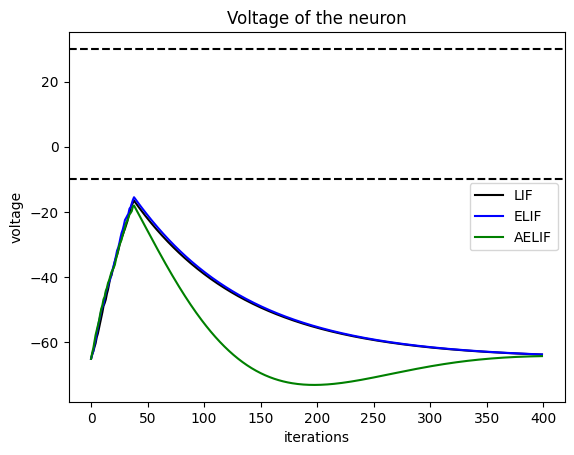

Text(0.5, 1.0, 'Input Current of LIF model')

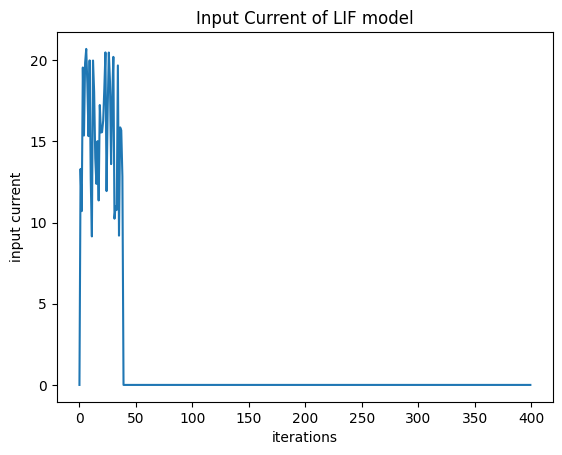

In [431]:
plt.plot(net1['voltage', 0][:,0:1], color = "black")
plt.plot(net2['voltage', 0][:,0:1], color = "blue")
plt.plot(net3['voltage', 0][:,0:1], color = "green")

plt.legend(["LIF", "ELIF", "AELIF"])

plt.axhline(ng3['AELIF_Behavior', 0].threshold, color='black', linestyle='--')
plt.axhline(ng3['AELIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
# for i, t in enumerate(net2['spike'][0]):
#     plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

plt.plot(net2['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')

# Custom Functions

In [101]:
def potential_plot(net, ng, behavior) :
    plt.plot(net['voltage', 0][:,0:1])
    plt.plot(net['torch.mean(voltage)', 0], color='black')
    plt.axhline(ng[behavior, 0].threshold, color='black', linestyle='--')
    plt.axhline(ng[behavior, 0].rh_threshold, color='black', linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.title('Voltage of the neuron')
    for i, t in enumerate(net['spike'][0]):
        plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
    plt.show()

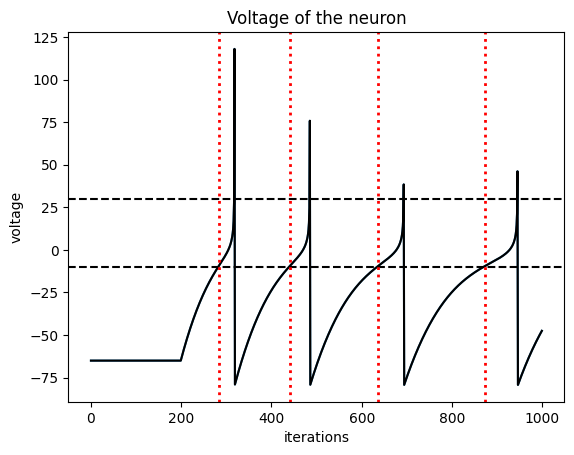

In [1202]:
potential_plot(net, ng, 'AELIF_Behavior')

In [1203]:
def run_manual(behavior, md, plot = True, pw = 20) : 
    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        1 : behavior(mode = md, pw = pw),
        9 : Recorder(['voltage', 'torch.mean(voltage)']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    if(plot) : 
        potential_plot(net, ng, behavior.__name__)

# Refractory

In [194]:
class Refractory_AELIF_Behavior(Behavior) : 

    def initialize(self, neuron) : 
        super().initialize(neuron)

        # main LIF
        # -----------------------------------------------------------

        self.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -80)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 0.1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("normal(-65, 10)") * neuron.rest

        # Exponential parameters

        self.rh_threshold = self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 4)

        neuron.spike_zone = False

        # Adaptability
        # -----------------------------------------------------------
        
        neuron.a = self.parameter("a", 0.1) # sub-threshold adaptation variable
        neuron.b = self.parameter("b", 0.7) # spike-triggered adaptation variable

        neuron.w = 0 # adaptive variable
        neuron.adpt_tau = self.parameter("adpt_tau", 30) # time-constant for w

        # Refractory parameters
        # -----------------------------------------------------------

        neuron.T = neuron.vector("zeros") # number of iterations for refractory period
        neuron.refractory_period = False 
        neuron.refractory_iter = self.parameter("ref_iter", 20)

    def forward(self, neuron) : 
        firing = torch.BoolTensor([(neuron.voltage >= self.rh_threshold and not neuron.spike_zone)])
            
        if(firing) : 
            neuron.spike_zone = True
        elif(not firing and neuron.voltage < self.rh_threshold) :
            neuron.spike_zone = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= self.threshold
        neuron.voltage[reset_need] = neuron.rest

        if(reset_need) : 
            neuron.T = neuron.refractory_iter
            neuron.refractory_period = True

        neuron.T = max(neuron.T - 1, 0)
        if(neuron.T == 0) : 
            neuron.refractory_period = False

        strike = not (neuron.spike_zone and (neuron.I < 0))
        dV = (
            -(neuron.voltage - neuron.rest) * (not neuron.spike_zone)
            + neuron.delta*torch.exp(torch.tensor([(neuron.voltage - self.rh_threshold) / neuron.delta]))
            + neuron.R*neuron.I * (not neuron.refractory_period) * strike # refractory_period
            - neuron.R*neuron.w * (not neuron.spike_zone)
            ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt

        dW = (
            + neuron.a*(neuron.voltage - neuron.rest)
            - neuron.w
            + neuron.b*neuron.adpt_tau*(firing.byte())
        ) / neuron.adpt_tau

        neuron.w += dW * neuron.dt

In [195]:
net = Network()

ng = NeuronGroup(net = net, size = 10, behavior={
    0 : CurrentBehavior(pw = 50, has_noise = True, mode = "random"),
    1 : Refractory_AELIF_Behavior(ref_iter = 20),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [196]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(10)|1 groups, Synapses: tensor(100)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){0:CurrentBehavior(pw=50,has_noise=True,mode=random,)1:Refractory_AELIF_Behavior(ref_iter=20,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S10xD10){}


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [2]:
net['voltage', 0]

NameError: name 'net' is not defined

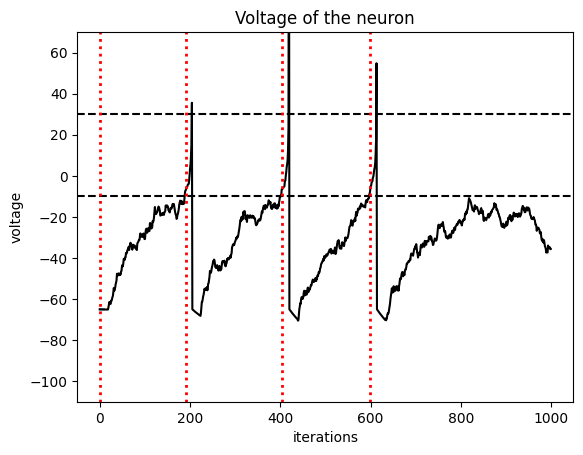

In [1714]:
plt.plot(net['voltage', 0][:10,0:10])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(ng['Refractory_AELIF_Behavior', 0].threshold, color='black', linestyle='--')
plt.axhline(ng['Refractory_AELIF_Behavior', 0].rh_threshold, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.ylim(top = 70, bottom = -110) 
plt.title('Voltage of the neuron')
for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

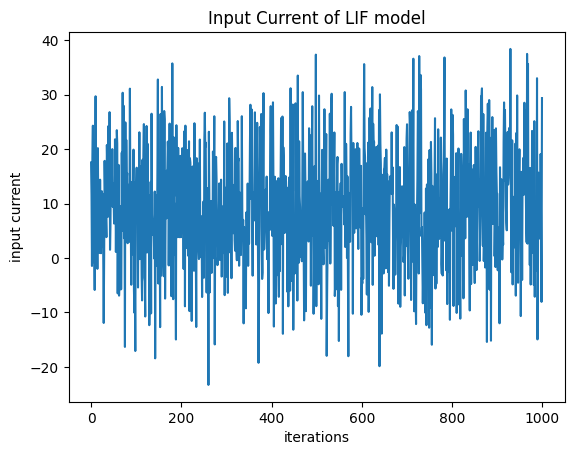

In [1709]:
plt.plot(net['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=12,has_noise=True,mode=trigeometric,)1:Refractory_AELIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 638.335ms


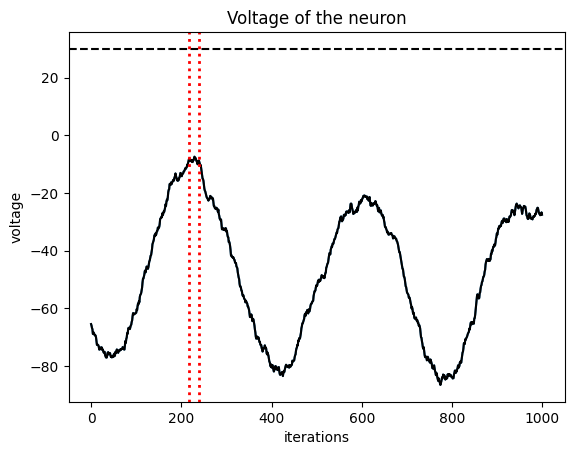

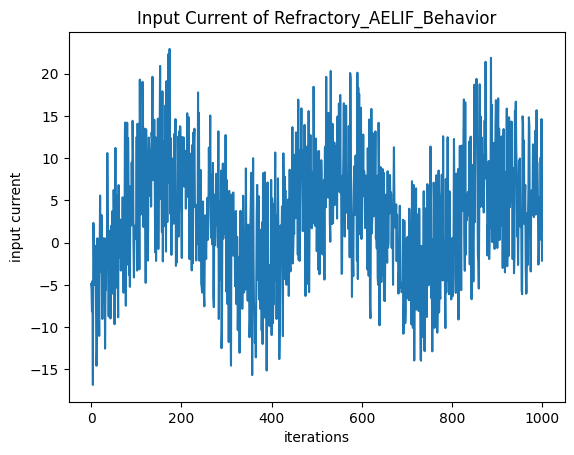

In [1512]:
Utils.run_manual({
    0 : CurrentBehavior(pw = 12, has_noise = True, mode = "trigeometric"),
    1 : Refractory_AELIF_Behavior(),
})

# I-F curve

## LIF

In [1084]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    1 : LIF_Behavior(pw = 10),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:LIF_Behavior(pw=10,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 411.940ms


411.9398593902588

tensor([[283,   0],
        [373,   0],
        [467,   0],
        [554,   0],
        [651,   0],
        [745,   0],
        [838,   0],
        [930,   0]])

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:LIF_Behavior(pw=0.0,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 652.277ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:LIF_Behavior(pw=0.1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}

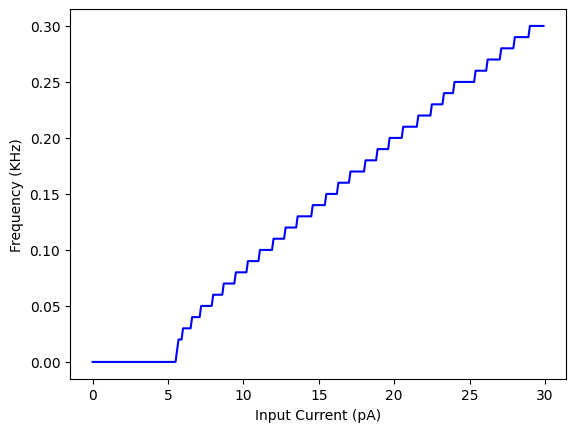

In [1099]:
a_freq_lst = []
a_inp_cur_lst = []

for inp_cur in range(0, 300) : 
    pwer = inp_cur / 10    


    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        1 : LIF_Behavior(pw = pwer),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    a_inp_cur_lst.append(pwer)
    a_freq_lst.append(len(net['spike'][0]) / 100)

plt.plot(a_inp_cur_lst, a_freq_lst, color = "blue")
plt.xlabel('Input Current (pA)')
plt.ylabel('Frequency (KHz)')
plt.show()

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:ELIF_Behavior(pw=0.0,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 934.497ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:ELIF_Behavior(pw=0.1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1)

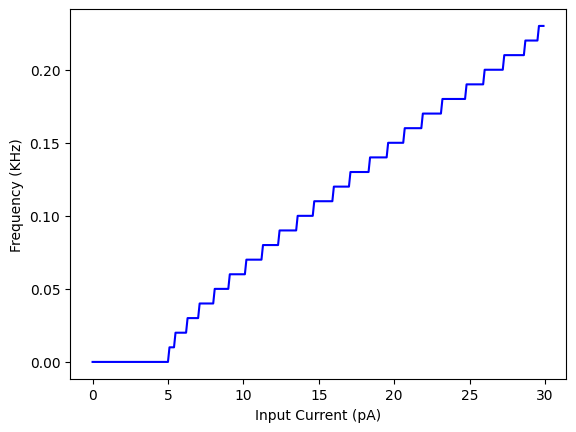

In [1100]:
b_freq_lst = []
b_inp_cur_lst = []

for inp_cur in range(0, 300) : 
    pwer = inp_cur / 10    


    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        1 : ELIF_Behavior(pw = pwer),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    b_inp_cur_lst.append(pwer)
    b_freq_lst.append(len(net['spike'][0]) / 100)

plt.plot(b_inp_cur_lst, b_freq_lst, color = "blue")
plt.xlabel('Input Current (pA)')
plt.ylabel('Frequency (KHz)')
plt.show()

In [1227]:
a = {0 : 12}
b = {1 : 3}
a.update(b)
a

{0: 12, 1: 3}

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:AELIF_Behavior(pw=0.0,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 668.213ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){1:AELIF_Behavior(pw=0.1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD

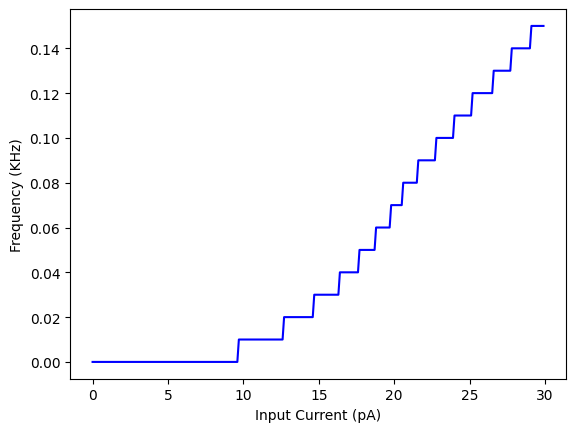

In [1101]:
c_freq_lst = []
c_inp_cur_lst = []

for inp_cur in range(0, 300) : 
    pwer = inp_cur / 10    


    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        1 : AELIF_Behavior(pw = pwer),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    c_inp_cur_lst.append(pwer)
    c_freq_lst.append(len(net['spike'][0]) / 100)

plt.plot(c_inp_cur_lst, c_freq_lst, color = "blue")
plt.xlabel('Input Current (pA)')
plt.ylabel('Frequency (KHz)')
plt.show()

In [1098]:
def is_gay(name):
    return True

name = "mamad"
print(is_gay(name=name))

True


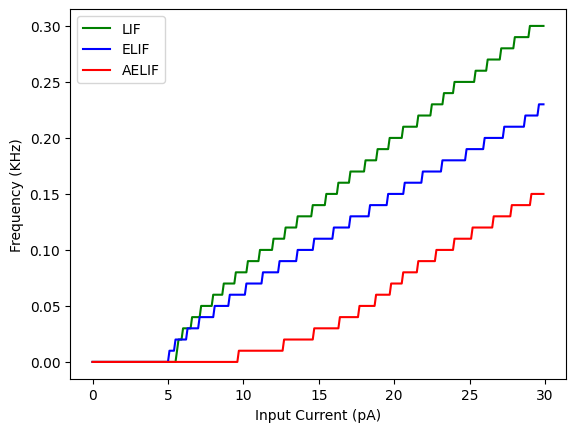

In [1300]:
plt.plot(a_inp_cur_lst, a_freq_lst, color = "green")
plt.plot(b_inp_cur_lst, b_freq_lst, color = "blue")
plt.plot(c_inp_cur_lst, c_freq_lst, color = "red")
plt.legend(["LIF", "ELIF", "AELIF"], loc="upper left")
plt.xlabel('Input Current (pA)')
plt.ylabel('Frequency (KHz)')
plt.show()

In [1290]:
from uts import Utils

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=0.02,has_noise=False,mode=stair,)1:LIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 442.817ms


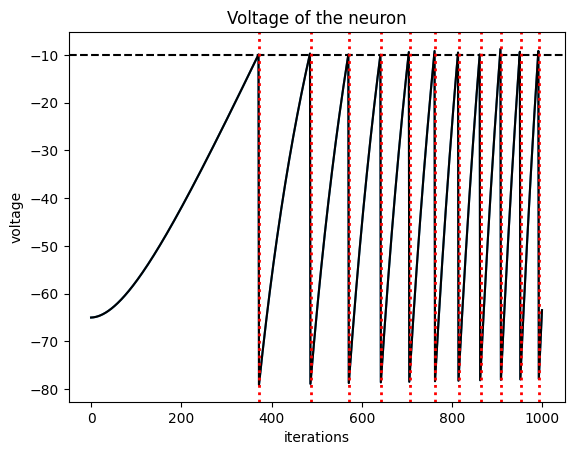

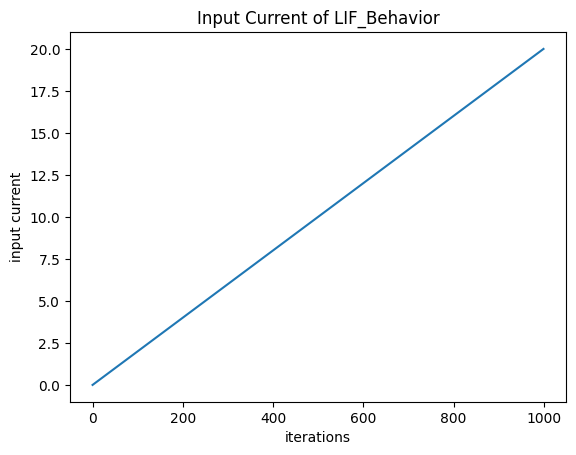

In [1328]:
Utils.run_manual({
    0 : CurrentBehavior(pw = 0.02, has_noise = False, mode = "stair"),
    1 : LIF_Behavior(),
})

In [1333]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 10, has_noise = False, mode = "trigeometric"),
    1 : LIF_Behavior(),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [1334]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=trigeometric,)1:LIF_Behavior()9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 441.816ms


441.8158531188965

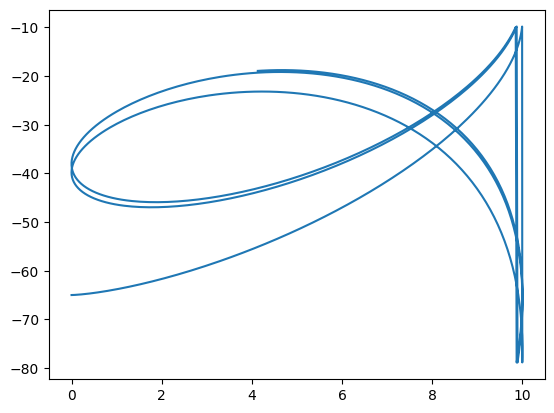

In [1335]:
plt.plot(net["I", 0], net["voltage", 0])
plt.show()

In [1320]:
print(net["voltage", 0][100:105])
print(net["I", 0][100:105])

tensor([[-47.2445],
        [-46.8181],
        [-46.3874],
        [-45.9526],
        [-45.5136]])
tensor([[5.9540],
        [6.0396],
        [6.1248],
        [6.2096],
        [6.2941]])


In [1366]:
a_freq_lst = []
a_tau_lst = []

for i in range(1, 100) : 
    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        0 : CurrentBehavior(pw = 20, has_noise = False, mode = "constant"),
        1 : LIF_Behavior(tau = i),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    a_freq_lst.append(len(net['spike'][0]) / 100)
    a_tau_lst.append(i)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:LIF_Behavior(tau=1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 437.830ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:LIF_Behavior(tau=2,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,ar

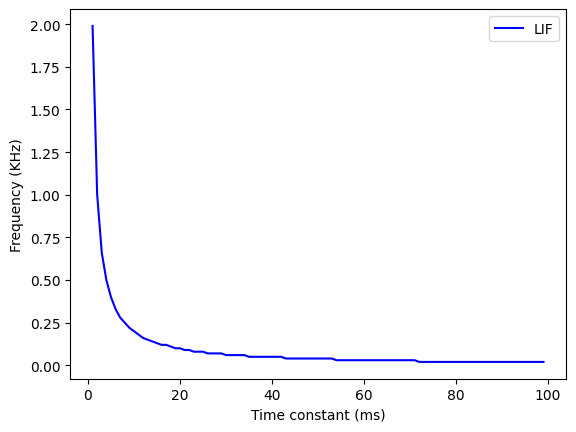

In [1360]:
plt.plot(tau_lst, freq_lst, color = "blue")
plt.xlabel('Time constant (ms)')
plt.ylabel('Frequency (KHz)')
plt.legend(["LIF"])
plt.show()

In [1365]:
b_freq_lst = []
b_tau_lst = []

for i in range(1, 100) : 
    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        0 : CurrentBehavior(pw = 20, has_noise = False, mode = "constant"),
        1 : ELIF_Behavior(tau = i),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    b_freq_lst.append(len(net['spike'][0]) / 100)
    b_tau_lst.append(i)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:ELIF_Behavior(tau=1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 541.551ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:ELIF_Behavior(tau=2,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,

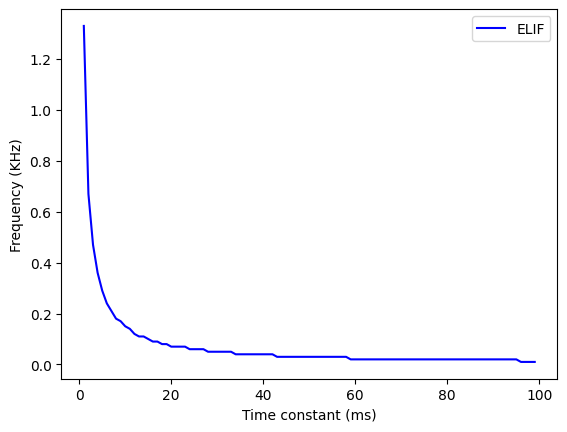

In [1367]:
plt.plot(b_tau_lst, b_freq_lst, color = "blue")
plt.xlabel('Time constant (ms)')
plt.ylabel('Frequency (KHz)')
plt.legend(["ELIF"])
plt.show()

In [1370]:
neurons = [LIF_Behavior, ELIF_Behavior, AELIF_Behavior]

freq_lst_all = []
tau_lst_all = []

for n in range(len(neurons)) :
    freq_lst_all.append([])
    tau_lst_all.append([])

    for i in range(1, 100) : 
        net = Network()

        ng = NeuronGroup(net = net, size = 1, behavior={
            0 : CurrentBehavior(pw = 40, has_noise = False, mode = "constant"),
            1 : neurons[n](tau = i),
            9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
            10 : EventRecorder(['spike'])
        })

        syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

        net.initialize()
        net.simulate_iterations(1000)

        freq_lst_all[n].append(len(net['spike'][0]) / 100)
        tau_lst_all[n].append(i)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=40,has_noise=False,mode=constant,)1:LIF_Behavior(tau=1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 445.849ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=40,has_noise=False,mode=constant,)1:LIF_Behavior(tau=2,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,ar

In [1368]:
c_freq_lst = []
c_tau_lst = []

for i in range(1, 100) : 
    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        0 : CurrentBehavior(pw = 40, has_noise = False, mode = "constant"),
        1 : AELIF_Behavior(tau = i),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    c_freq_lst.append(len(net['spike'][0]) / 100)
    c_tau_lst.append(i)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:AELIF_Behavior(tau=1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 624.331ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=20,has_noise=False,mode=constant,)1:AELIF_Behavior(tau=2,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=Non

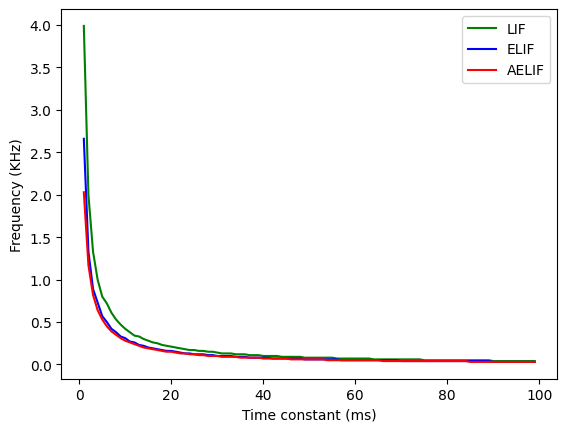

In [1371]:
colors = ["green", "blue", "red"]
nrns = ["LIF", "ELIF", "AELIF"]

for i in range(len(nrns)) : 
    plt.plot(tau_lst_all[i], freq_lst_all[i], color = colors[i])
    
plt.xlabel('Time constant (ms)')
plt.ylabel('Frequency (KHz)')
plt.legend(nrns)
plt.show()

In [338]:
class Adaptive_RAELIF(Behavior) :
    
    def initialize(self, neuron) : 
        super().initialize(neuron)

        # main LIF
        # -----------------------------------------------------------
        neuron.threshold = self.parameter("threshold", 30)
        neuron.reset = self.parameter("reset", -120)
        neuron.rest = self.parameter("rest", -65)
        neuron.tau = self.parameter("tau", 10)
        neuron.dt = self.parameter("dt", 0.1)
        neuron.R = self.parameter("R", 10)

        neuron.voltage = neuron.vector("ones") * neuron.rest

        # Exponential parameters

        neuron.rh_threshold = neuron.vector("ones") * self.parameter("rh_threshold", -10)
        neuron.delta = self.parameter("delta", 1)

        neuron.spike_zone = neuron.vector("zeros")

        # Adaptability
        # -----------------------------------------------------------
        
        self.a = self.parameter("a", 0.1) # sub-threshold adaptation variable
        self.b = self.parameter("b", 0.7) # spike-triggered adaptation variable

        neuron.w = neuron.vector("zeros") # adaptive variable
        self.adpt_tau = self.parameter("adpt_tau", 30) # time-constant for w

        # Refractory parameters
        # -----------------------------------------------------------

        neuron.T = neuron.vector("zeros") # number of iterations for refractory period
        neuron.refractory_period = neuron.vector("zeros")
        neuron.refractory_iter = self.parameter("refractory_iter", 20)

        # Adaptive Threshold
        # -----------------------------------------------------------

        neuron.tau_thresh_adpt = self.parameter("tau_thresh_adpt", 100) # adaptive threshold time constant
        neuron.eps = self.parameter("eps", 5) # epsilon changes of threshold when spiking
        neuron.base_threshold = -10

    def forward(self, neuron) : 
        firing = torch.logical_and((neuron.voltage >= neuron.rh_threshold), torch.logical_not(neuron.spike_zone))
        deactive = torch.logical_and((neuron.voltage < neuron.rh_threshold), torch.logical_not(firing))
        
        neuron.spike_zone[firing] = True
        neuron.spike_zone[deactive] = False
        
        neuron.spike = firing.byte()
            
        reset_need = neuron.voltage >= neuron.threshold
        neuron.voltage[reset_need] = neuron.reset

        neuron.T[reset_need] = neuron.refractory_iter
        neuron.refractory_period[reset_need] = True

        neuron.T = neuron.T - 1
        neuron.T[neuron.T < 0] = 0
        
        neuron.refractory_period[neuron.T == 0] = False

        strike = torch.logical_not(torch.logical_and(neuron.spike_zone, (neuron.I < 0)))

        dV = (
            -(neuron.voltage - neuron.rest) + (-(neuron.voltage - neuron.rest) * 20 * neuron.refractory_period)
            + neuron.delta * torch.exp((neuron.voltage - neuron.rh_threshold) / neuron.delta)
            + neuron.R*neuron.I * (torch.logical_not(neuron.refractory_period)) * strike # refractory_period
            - neuron.R*neuron.w * (torch.logical_not(neuron.spike_zone))
            ) / neuron.tau
        
        neuron.voltage += dV * neuron.dt
        neuron.voltage = torch.minimum(neuron.voltage, neuron.vector(100))
        
        dW = (
            + self.a * (neuron.voltage - neuron.rest)
            - neuron.w
            + self.b * self.adpt_tau*(neuron.spike)
        ) / self.adpt_tau

        neuron.w += dW * neuron.dt

        dTh = (
            - (neuron.rh_threshold - neuron.base_threshold)     
            + neuron.eps * neuron.spike
        ) / neuron.tau_thresh_adpt

        neuron.rh_threshold += dTh * neuron.dt

In [368]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 50, has_noise = False, mode = "constant"),
    1 : Adaptive_RAELIF(
        tau_thresh_adpt = 50,
        eps = 150
    ),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [369]:
net.initialize()
net.simulate_iterations(100)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=50,has_noise=False,mode=constant,)1:Adaptive_RAELIF(tau_thresh_adpt=50,eps=150,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
100xBatch: 1/1 (100%) 163.563ms


163.56277465820312

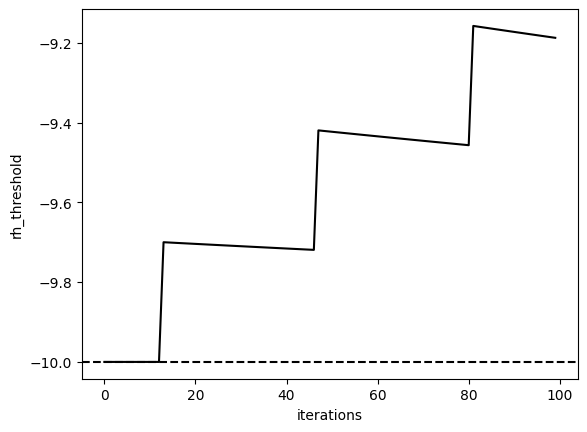

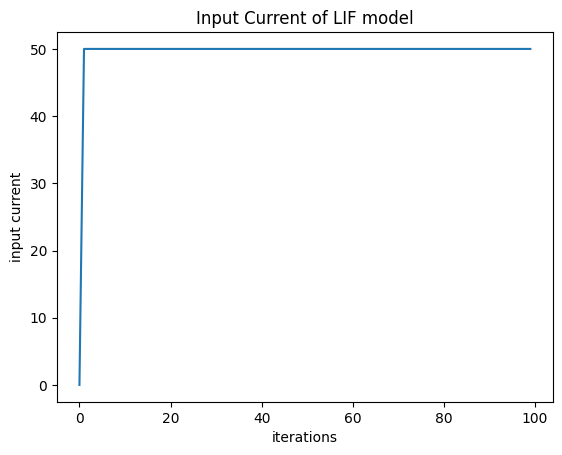

In [370]:

# plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.plot(net['rh_threshold', 0][:, :1], color='black')
plt.axhline(-10, color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('rh_threshold')

plt.show()

plt.plot(net['I', 0][:,0:1])
plt.xlabel('iterations')
plt.ylabel('input current')
plt.title('Input Current of LIF model')
plt.show()

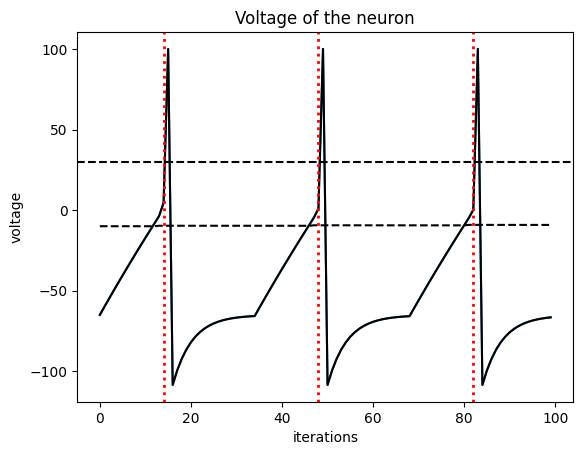

In [371]:
plt.plot(net['voltage', 0][:,:1])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(30, color='black', linestyle='--')
plt.plot(net['rh_threshold', 0][:, :1], color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.title('Voltage of the neuron')
for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

# Main Experiments

In [2166]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 10, has_noise = False, mode = "constant", dt = 1),
    1 : Adaptive_RAELIF(tau = 2),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [2001]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=constant,dt=1,)1:Adaptive_RAELIF(tau=3,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 840.791ms


840.7914638519287

In [2007]:
def short_pulse(cnt) : 
    return 10 * (cnt > 100 and cnt < 200)

In [2185]:
net = Network()

ng = NeuronGroup(net = net, size = 1, behavior={
    0 : CurrentBehavior(pw = 10, has_noise = False, mode = "step", dt = 1),
    1 : Adaptive_RAELIF(adpt_tau = 50),
    9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold']),
    10 : EventRecorder(['spike'])
})

syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

In [2186]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=step,dt=1,)1:Adaptive_RAELIF(adpt_tau=50,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 872.708ms


872.7076053619385

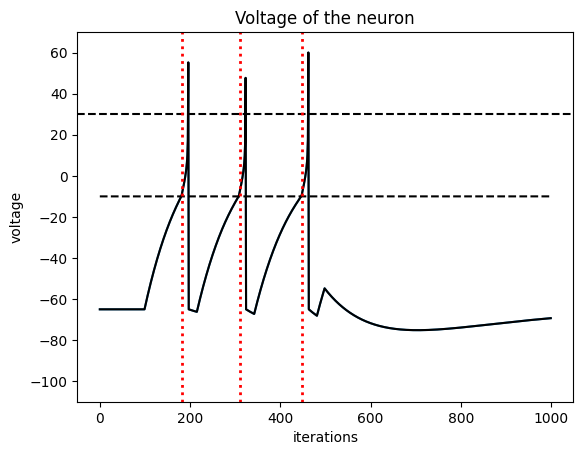

In [2187]:
plt.plot(net['voltage', 0][:,:1])
plt.plot(net['torch.mean(voltage)', 0], color='black')
plt.axhline(30, color='black', linestyle='--')
plt.plot(net['rh_threshold', 0][:, :1], color='black', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('voltage')
plt.ylim(top = 70, bottom = -110) 
plt.title('Voltage of the neuron')
for i, t in enumerate(net['spike'][0]):
    plt.axvline(t[0].item(), ls=':', c='r', lw=2, label='Spikes' if i==0 else None)
plt.show()

Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=constant,dt=1,)1:Adaptive_RAELIF(R=1,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold'],)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spike'],)}
SynapseGroup['GLUTAMATE', 'SynapseGroup', 'syn', 'NeuronGroup_1 => NeuronGroup_1'](S1xD1){}
1000xBatch: 1/1 (100%) 924.559ms
Network['Network'](Neurons: tensor(1)|1 groups, Synapses: tensor(1)|1 groups){}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](1){0:CurrentBehavior(pw=10,has_noise=False,mode=constant,dt=1,)1:Adaptive_RAELIF(R=2,)9:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold'],)10:EventRecorder(variables=None,gap_width=0,ma

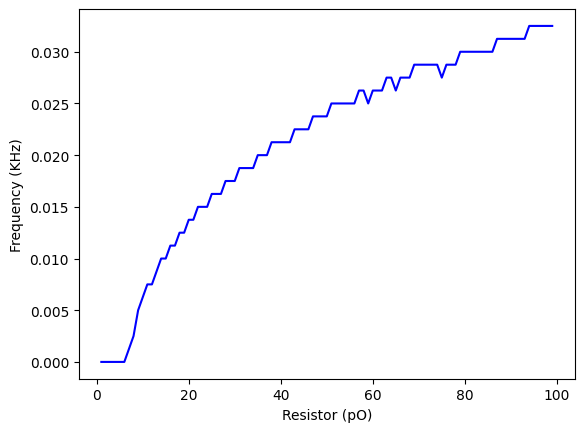

In [2041]:
a_freq_lst = []
a_inp_cur_lst = []

for r in range(1, 100) :   

    net = Network()

    ng = NeuronGroup(net = net, size = 1, behavior={
        0 : CurrentBehavior(pw = 10, has_noise = False, mode = "constant", dt = 1),
        1 : Adaptive_RAELIF(R = r),
        9 : Recorder(['voltage', 'torch.mean(voltage)', 'I', 'rh_threshold']),
        10 : EventRecorder(['spike'])
    })

    syn = SynapseGroup(net=net, src=ng, dst=ng, tag='GLUTAMATE')

    net.initialize()
    net.simulate_iterations(1000)

    a_inp_cur_lst.append(r)
    a_freq_lst.append(len(net['spike'][0]) / 800)

plt.plot(a_inp_cur_lst, a_freq_lst, color = "blue")
plt.xlabel('Resistor (pO)')
plt.ylabel('Frequency (KHz)')
plt.show()